# Rainfall-runoff preprocessing
This Notebook guides through several processing steps which aim to prepare catchment data as well as precipitation and discharge time-series data for rainfall-runoff modeling.

First, load some R-scripts that provide different processing functions we will use in this notebook.

## Preparation

In [1]:
# Loading these sources may produce some warning messages due to GDAL library loading errors
# if GDAL_DRIVER_PATH envvar is set, which can be ignored.
# Uncomment to suppress warnings
# options(warn=-1)
source("./R/data_io.R")
source("./R/plot.R")
source("./R/preprocess.R")
# Uncomment to turn back on warnings
# options(warn=0)

Loading required package: sp

code for methods in class "Rcpp_SpExtent" was not checked for suspicious field assignments (recommended package 'codetools' not available?)

code for methods in class "Rcpp_SpExtent" was not checked for suspicious field assignments (recommended package 'codetools' not available?)

code for methods in class "Rcpp_SpPoly" was not checked for suspicious field assignments (recommended package 'codetools' not available?)

code for methods in class "Rcpp_SpPoly" was not checked for suspicious field assignments (recommended package 'codetools' not available?)

code for methods in class "Rcpp_SpPolyPart" was not checked for suspicious field assignments (recommended package 'codetools' not available?)

code for methods in class "Rcpp_SpPolyPart" was not checked for suspicious field assignments (recommended package 'codetools' not available?)

code for methods in class "Rcpp_SpPolygons" was not checked for suspicious field assignments (recommended package 'codetools

## Landcover frequency calculation
### Load basin and land cover data

Now, we have to load basin and subbasin datasets as simple features and a raster dataset that contains land cover information. We will use these datasets for our preprocessing.

In [2]:
# Set path to required datasets
basin_file <- "./data/wv_basin.geojson"
subbasin_file <- "./data/wv_subbasins.geojson"
raster_file <- "./data/land_cover.tif"

# Read catchment polygons and land cover raster
basin <- load_catchments_as_sf(basin_file)
subbasins <- load_catchments_as_sf(subbasin_file)
land_cover <- load_land_cover_rasters(raster_file)

Reading layer `wv_basin' from data source `C:\Users\Sebastian\Entwicklung\Projekte\HSBO\promotion\rainfall-runoff-preprocessing\data\wv_basin.geojson' using driver `GeoJSON'
Simple feature collection with 1 feature and 2 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: 355826.3 ymin: 5650214 xmax: 402251.9 ymax: 5686235
projected CRS:  ETRS89 / UTM zone 32N
Reading layer `wv_catchments' from data source `C:\Users\Sebastian\Entwicklung\Projekte\HSBO\promotion\rainfall-runoff-preprocessing\data\wv_subbasins.geojson' using driver `GeoJSON'
Simple feature collection with 26 features and 3 fields
geometry type:  POLYGON
dimension:      XY
bbox:           xmin: 358476.1 ymin: 5652665 xmax: 402231.9 ymax: 5686145
projected CRS:  ETRS89 / UTM zone 32N


Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
"Discarded datum Unknown based on GRS80 ellipsoid in CRS definition,
 but +towgs84= values preserved"


### Calculate land cover class frequency

Next, we can calculate the land cover class frequencies for each of the subbasin polygons. For each subbasin 
1) raster cells from the land cover raster dataset that lie within a certain polygon are extracted and
2) raster cells of identical land cover class will be counted and the relative frequency of each class calculated.

After processing, we check if the relative land cover class frequency for each catchment sums up to 1.

In [3]:
# Calculate the land cover class frequencies for a selected catchment
subbasin <- subbasins %>% filter(id == c(100060))
res <- calculate_land_cover_frequency(subbasin, land_cover, TRUE)

# The relative class frequency for each catchment sums up to 1 should
# be TRUE.
if (res %>%
    group_by(id) %>%
    summarise(sum = sum(freq)) %>%
    filter(sum != 1) %>% nrow() == 0) {
  print("Land cover classes have been calculated properly for each catchment!")
} else {
  print("Relative land cover classes does not sums up to 1 for one of the catchments!")
}

Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
"Discarded datum Unknown based on GRS80 ellipsoid in CRS definition,
 but +towgs84= values preserved"
Warning message in showSRID(SRS_string, format = "PROJ", multiline = "NO"):
"Discarded datum European_Terrestrial_Reference_System_1989 in CRS definition"


[1] "Land cover classes have been calculated properly for each catchment!"


The resulting dataset contains for each combination of a subbasin and the land cover classes that lie within the subbasin's polygon a separate entry. Hence, you will notice multiple entries for a single subbasin, each one holds the absolute count of raster cells of a certain class and the relative frequency.

In [4]:
print(res)

Simple feature collection with 10 features and 6 fields
geometry type:  POLYGON
dimension:      XY
bbox:           xmin: 369195 ymin: 5670565 xmax: 377954.2 ymax: 5678715
projected CRS:  ETRS89 / UTM zone 32N
   fid     id      name class count        freq                       geometry
1    1 100060 Beckeraue     2  1691 0.418564356 POLYGON ((373384.6 5678715,...
2    1 100060 Beckeraue     3   200 0.049504950 POLYGON ((373384.6 5678715,...
3    1 100060 Beckeraue    10    39 0.009653465 POLYGON ((373384.6 5678715,...
4    1 100060 Beckeraue    12     9 0.002227723 POLYGON ((373384.6 5678715,...
5    1 100060 Beckeraue    18   323 0.079950495 POLYGON ((373384.6 5678715,...
6    1 100060 Beckeraue    20   360 0.089108911 POLYGON ((373384.6 5678715,...
7    1 100060 Beckeraue    21    96 0.023762376 POLYGON ((373384.6 5678715,...
8    1 100060 Beckeraue    23   827 0.204702970 POLYGON ((373384.6 5678715,...
9    1 100060 Beckeraue    24   162 0.040099010 POLYGON ((373384.6 5678715,...
1

### Plot land cover frequency for subbasin
Finally, we can select a single catchment and plot its land cover class frequency.

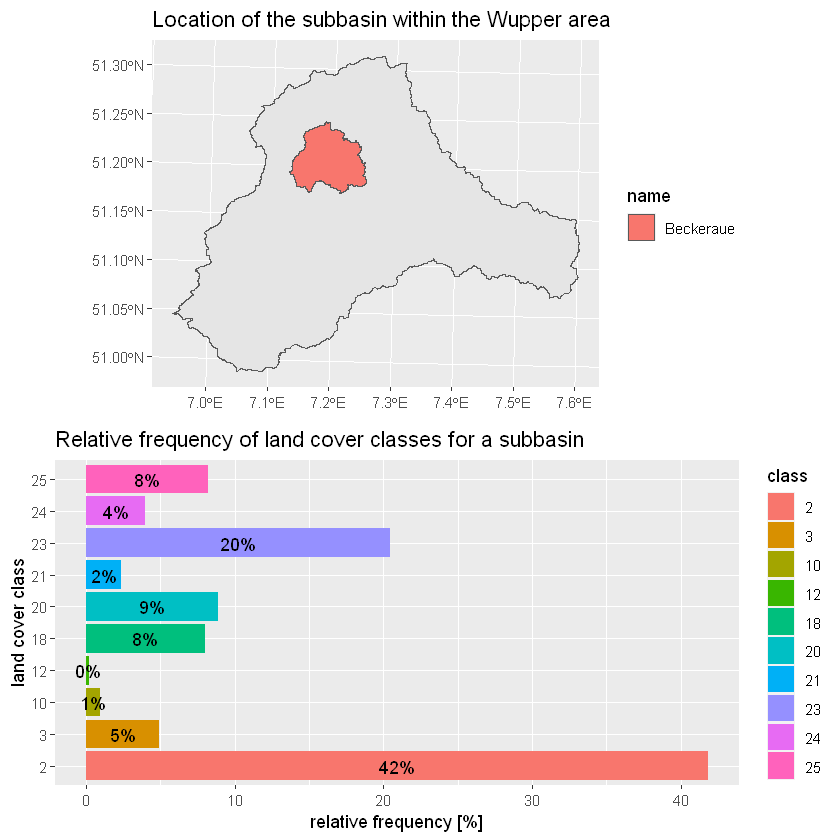

In [5]:
# Plot the landcover class frequencies
landcover_classes <- res %>% filter(id == c(100060))

plot_landcover_frequency(basin, subbasin, landcover_classes, "bar")

## Preprocess DWD REGNIE data
### Load REGNIE dataset

Next, we want to determine the mean daily precipitation per day for each subbasin over several years. To do so, we use the REGNIE dataset from DWD (German Weather Service). The DWD provides the REGNIE dataset in different resolutions: daily, monthly and annual. However, for our studies we require precipitation timeseries on a daily scale. Since this project **does not come with REGNIE datasets**, you have to fetch a certain dataset on your own. Please, download one of the TAR-archives that contains ASCII raster files with daily precipitation for a whole year from  the DWD FTP server (ftp://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/regnie/),unzip it and adjust the first two lines in the following code block.

In [6]:
# Absolute path to the base directory, which contains one or more folders that
# hold the daily REGNIE precipitation data
base_path <- "/path/to/REGNIE/" # TODO: set absolute path to REGNIE folder
year <- 2020 # choose the year to load

path <- paste0(base_path, "ra", 2020, "m")

Next, with a single path (or multiple paths) we are able to create a list of
absolute paths to all single ASCII files within a single (or multiple) annual 
folder. With those paths, we load the REGNIE datasets as a multidimensional
stars object with three dimensions _x_, _y_ and _date_. Finally, let's plot
a small subset of our timeseries raster dataset.

 100 % completed

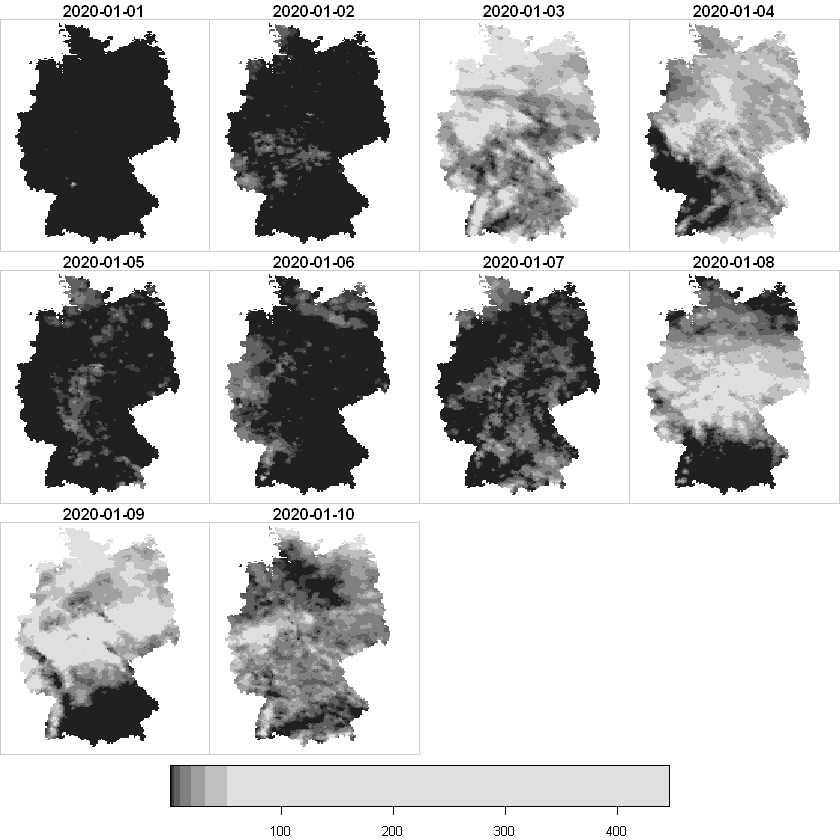

In [7]:
# Read all files from a directory that contains the REGNIE files for a certain year
files <- create_regnie_file_list(path)
# Load REGNIE raster files as stars for a subset
stars <- load_regnie_as_stars(files[1:10,])
plot(stars)

### Calculate precipitation means
With the spatio-temporal raster objects, we now can calculate the daily mean precipitation for single basins. Be sure, that the subbasin feature and the stars object have the same CRS. The function `calculate_precipitation_means` crops the stars object by the use of the subbasin's polygon and aggregates all raster cells that lie within the polygon to the mean along the date dimension. This results in a data frame containin a timeseries with daily mean precipitation for a certain catchment. 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



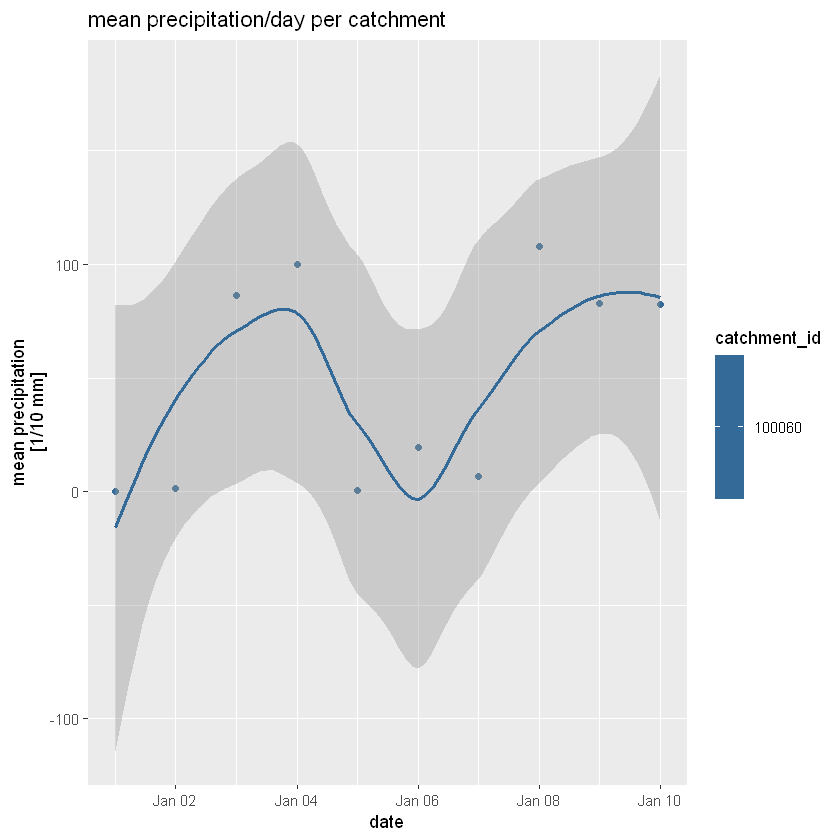

In [8]:
subbasin <- subbasins %>% filter(id == c(100060)) %>% st_transform(st_crs(stars))

precipitation <- calculate_precipitation_means(stars, subbasin)
precipitation <- precipitation %>% rename(precipitation = mean)

ggplot(data = precipitation, (aes(x = date, y = precipitation, color = catchment_id))) + 
  geom_point() +
  geom_smooth() +
  labs(y = "mean precipitation\n[1/10 mm]", title = "mean precipitation/day per catchment")